<a href="https://colab.research.google.com/github/kundana12345/DataScience/blob/main/KA_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

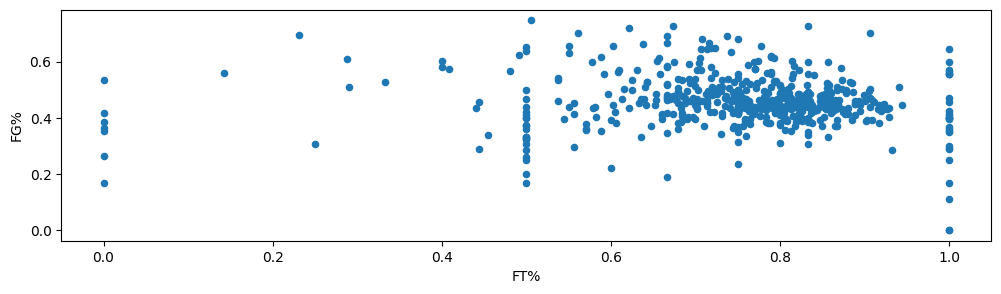

In [5]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind = "scatter")

Most of the points lie in between 0.6 and 0.85. I think this is because as players who are more likely to take more shots are also more likely to take more free throws.
There are straight lines of outliers at 0, 0.5, and 1.0. These are the players who took less shows so they have smaller number of varieties of being inside.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

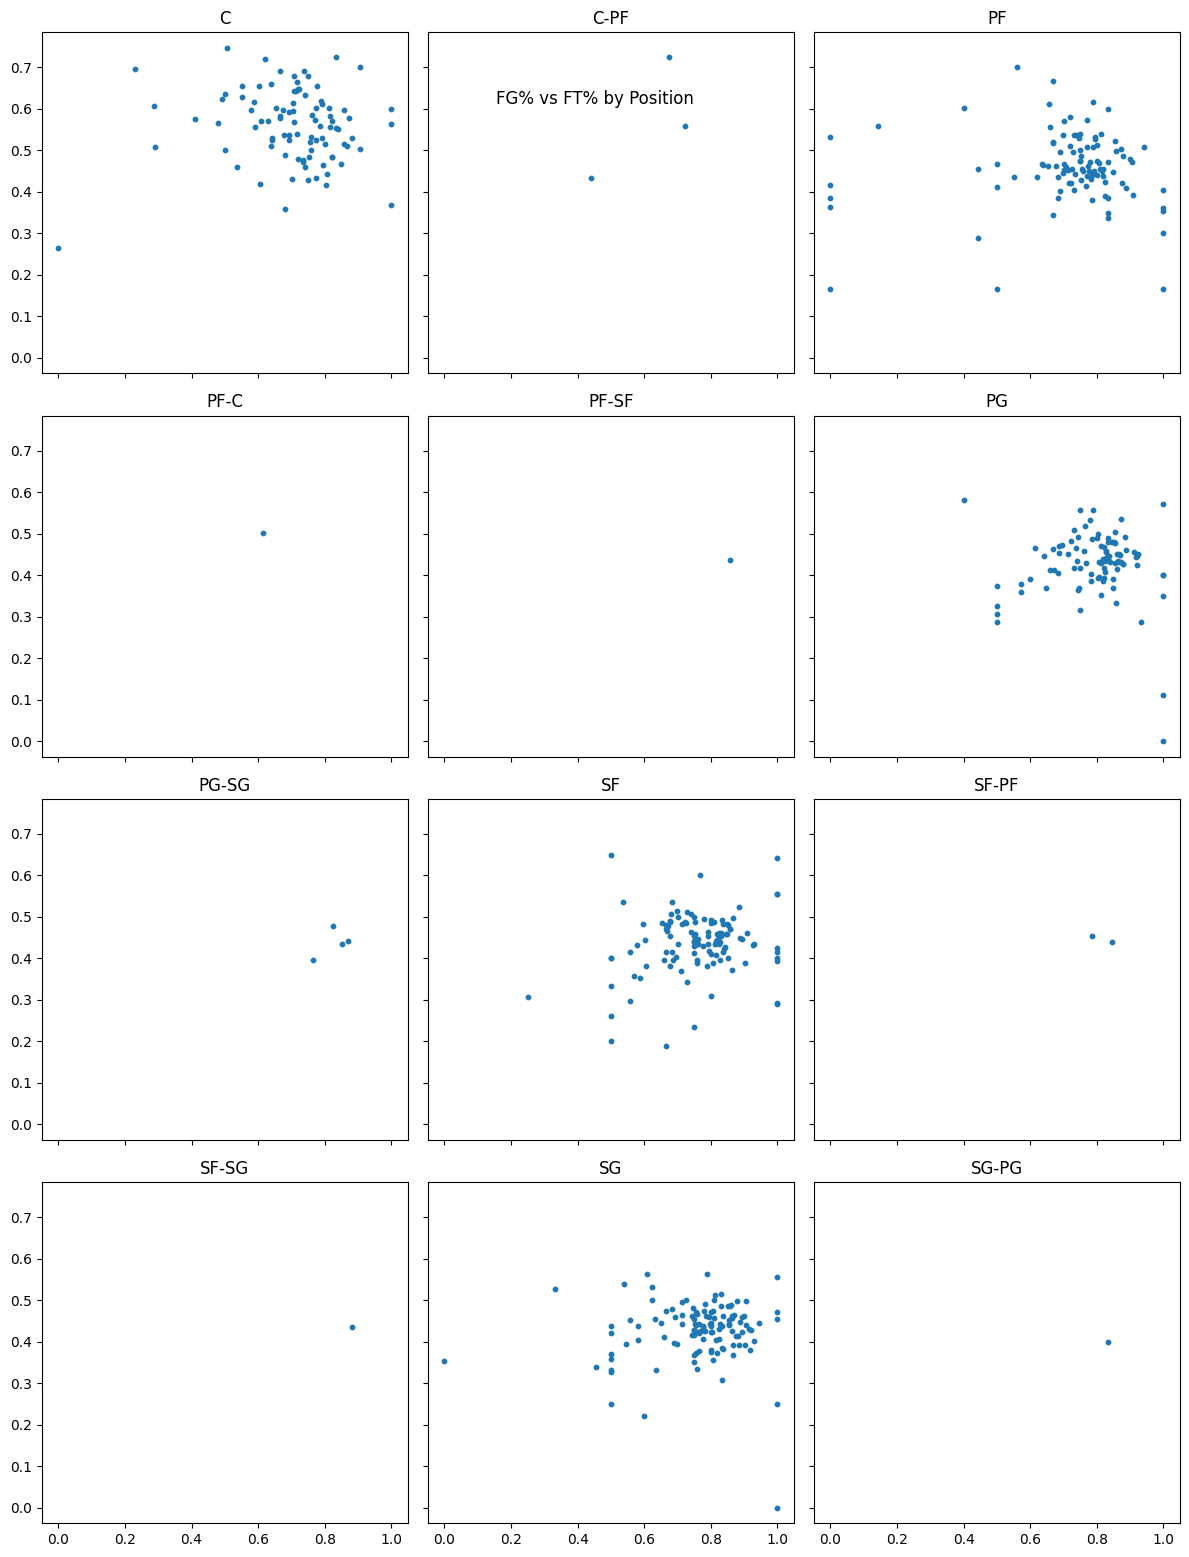

In [6]:
#used ChatGPT
# unique positions in the dataset
positions = basketball['Pos'].cat.categories.tolist()

# how many to plot
k = len(positions)

# set up grid that fits k plots; force 3 columns for readability
cols = 3
rows = (k + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, pos in enumerate(positions):
    data = basketball[basketball['Pos'] == pos]

    axes[i].scatter(data['FT%'], data['FG%'], s=10)
    axes[i].set_title(pos)


fig.suptitle("FG% vs FT% by Position", y=0.92)
plt.tight_layout()
plt.show()

C and PF have clusters near the top right.

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

There are some outliers that would sway the linear regression opposed to the trend that we can observe. They also look like clusters that wouldn't form a line. Some graphs only have one point, I don't think you can make a linear regression out of that.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [7]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [8]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

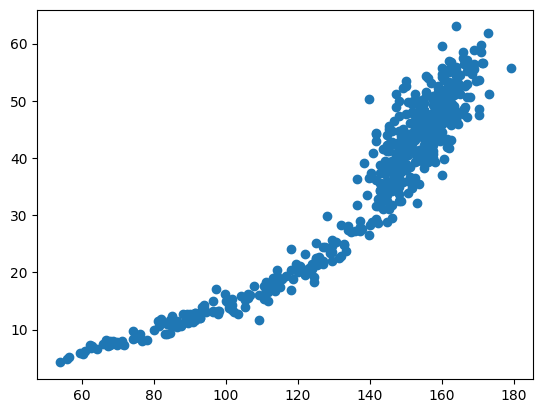

In [9]:
plt.scatter(howell['height'],howell['weight'])

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_lb = pm.sample()

Text(0, 0.5, 'weight')

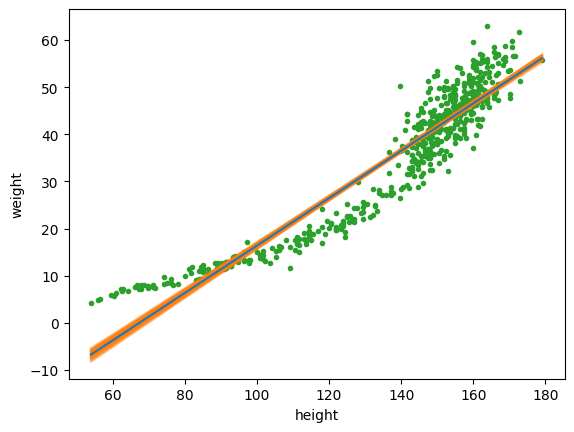

In [11]:
#grabs 100 posterior samples
posterior = az.extract(idata_lb, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

<Axes: xlabel='y_pred'>

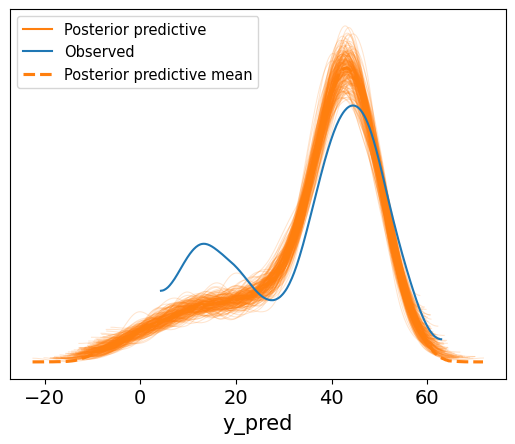

In [13]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

From 0 to 30, the predictions don't match the shape of the observed. Other than that, the model fits pretty well, with the same mode and shape.

Text(0, 0.5, 'weight')

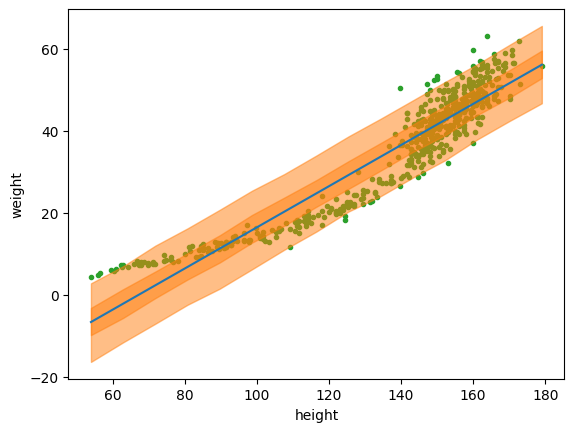

In [14]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
#ANSWER6

#lba stands for linear babies
with pm.Model() as model_lba:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_lba = pm.sample()


Text(0, 0.5, 'weight')

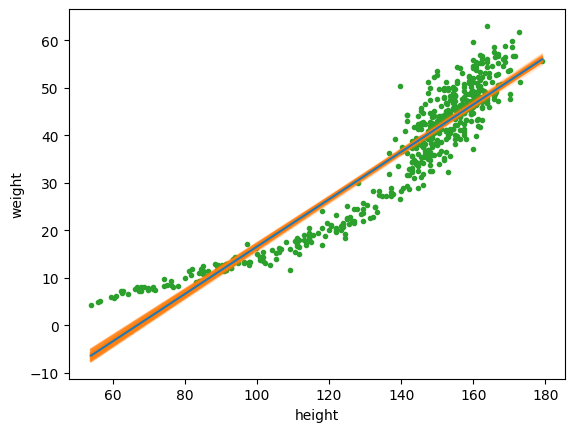

In [34]:
#grabs 100 posterior samples
posterior = az.extract(idata_lba, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [ ]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

<Axes: xlabel='y_pred'>

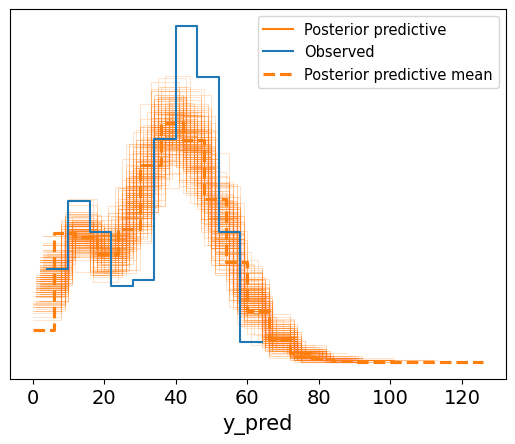

In [21]:
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'weight')

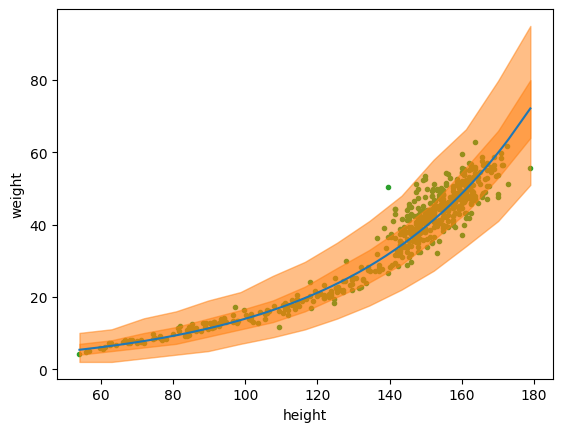

In [22]:
mean_line = idata_nbb.posterior["μ"].mean(("chain", "draw"))
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_nbb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")
